In [ ]:
from __future__ import annotations
import os, sys
from pathlib import Path
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as spc
import scipy.sparse as sp

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

_HERE = Path(__file__).resolve().parent if "__file__" in globals() else Path().resolve()
_SRC = _HERE.parent.parent
if str(_SRC) not in sys.path:
    sys.path.insert(0, str(_SRC))

from hamiltonian import Hamiltonian
from hamiltonian.tb.orbitals import Orbitals, Base
from hamiltonian.tb import tb_params
from negf.gf.functions import GFFunctions

class SiEMOrbitals(Orbitals):
    def __init__(self, onsite):
        super().__init__("SiEM")
        self.add_orbital("s", energy=onsite)

class DeviceStructure:
    def __init__(self):
        # Physical constants
        self.T = 300  # Kelvin
        self.kbT = spc.Boltzmann * self.T
        self.q = spc.e
        self.hbar = spc.hbar
        self.m = 0.45 * spc.m_e
        self.epsl = 8.854e-12 * 3.3
        self.epox = 8.854e-12 * 3.9

        # Geometry parameters
        self.a = 2.5e-10  # discretization spacing (m)
        self.L = 4e-9   # channel length (m)
        self.sd = 2e-9  # source/drain length (m)
        self.sp = 0     # spacer length (m)
        self.tox = 0.5e-9 # thickness of oxide layer
        self.Tch = 5.e-10 # thickness of the channel
        
        self.V_S = 0
        self.V_D = 0

        # Derived discretization parameters
        self.NL = int(np.ceil(self.L / self.a)) # total nuumber of atoms in channel 
        self.NSD = int(np.ceil(self.sd / self.a))
        self.NSP = int(np.ceil(self.sp / self.a))
        self.Nx = self.NL + 2 * (self.NSD + self.NSP) # total number of atoms in device (x direction only)
        self.x = np.linspace(0, (self.Nx - 1) * self.a, self.Nx) 

        # Density of states parameters
        self.n2d = (2 * self.m * self.kbT) / (self.hbar**2 * np.pi * 2) 
        self.n1d = 2 * np.sqrt(self.m * self.kbT / (self.hbar**2 * np.pi * 2))
        self.Nc = self.n2d

        #hamiltonian
        self.t0 = self.hbar**2/(2*self.m*self.a**2*self.q) # 
        self.H00 = np.array([[2 * self.t0]]) 
        self.H10 = np.array([[-self.t0]]) # coupling energy between leads and channel 
        self.orbitals = 1 # how many orbitals each atom has, for exam
        # Doping profile
        self.NB = 2*self.Nc*np.concatenate([
            np.ones(self.NSD), 
            np.zeros(self.NSP), 
            np.zeros(self.NL), 
            np.zeros(self.NSP), 
            np.ones(self.NSD)])

        # Flat-band voltage and barrier height
        self.VFB, self.phib = 0.35, 0.05

        # Voltage sweeps
        VV=21
        self.Vds=np.linspace(0,0.5,VV)
        self.Vgs=np.linspace(0,0.5,VV)
        
        self.nn = np.zeros((VV,VV,self.Nx))
        self.qg = np.zeros((VV,VV))
        
        # define orbitals here
        onsite_energy = 2 * self.t0

        Orbitals.orbital_sets = OrderedDict()
        siem_orb = SiEMOrbitals(onsite_energy)
        # create hamiltonian (we will only be using this hamiltonian object through out the solver)
        tb_params.PARAMS_SIEM_SIEM = {"ss_sigma": -self.t0}

        # Step 2: create the Hamiltonian object for a 1D line of SiEM orbitals
        self.ham = Hamiltonian(
            structure="line",
            nx=self.Nx,
            wire_symbol="SiEM",
            nn_distance=self.a * 1.01,
            transport_dir=[1, 0, 0],
            periodic_dirs=None,
            sparse_build=False,
            return_sparse=False,
            sort_axis="transport",
        )
        self.ham.initialize()
        self.gf = GFFunctions(self.ham, energy_grid=np.linspace(-5,5, 200), use_variable_blocks=True)
        # create GF_Functions we will only be using this object throughout the solver
        self.gf.set_occupation_profile(mode="fd_half", prefactor=self.n1d, kbT=self.kbT)
        self.current_mode = "transmission"  # options: 'transmission' or 'bond'
        self.current_bond_index = None
        



In [2]:
class Helper_functions:
    
    # Define F_1/2(x)
    def FD_half(x):
        '''
        Approximation of the Fermi-Dirac integral of order 1/2.
        Reference: http://dx.doi.org/10.1063/1.4825209
        '''
        v = x**4 + 50 + 33.6 * x * (1 - 0.68 * np.exp(-0.17 * (x + 1)**2))
        return 1 / (np.exp(-x) + 3 * np.pi**0.5 / 4 * v**(-3/8))

    # Define F_-1/2(x) as the derivative of F_1/2(x)
    def FD_minus_half(x):
        dx = x * 1e-6  
        return (Helper_functions.FD_half(x + dx) - Helper_functions.FD_half(x - dx)) / (2 * dx)

    def sparse_diag_product(A, B):
        """
        Compute diagonal elements of C = A * B efficiently for sparse matrices.

        Parameters:
            A (csr_matrix): sparse matrix in CSR format
            B (csc_matrix): sparse matrix in CSC format

        Returns:
            numpy.ndarray: diagonal elements of A*B
        """
        from scipy.sparse import csr_matrix, csc_matrix
        import numpy as np

        # Ensure A is CSR and B is CSC for efficient indexing
        if not isinstance(A, csr_matrix):
            A = csr_matrix(A)
        if not isinstance(B, csc_matrix):
            B = csc_matrix(B)

        n = A.shape[0]
        diag = np.zeros(n, dtype=complex)

        for i in range(n):
            # Get row i from A (CSR format)
            A_row_start, A_row_end = A.indptr[i], A.indptr[i+1]
            A_cols = A.indices[A_row_start:A_row_end]
            A_vals = A.data[A_row_start:A_row_end]

            # Get column i from B (CSC format)
    
            B_rows = B.indices[B.indptr[i]:B.indptr[i+1]]
            B_vals = B.data[B.indptr[i]:B.indptr[i+1]]

            # Compute intersection of indices efficiently
            ptr_a, ptr_b = 0, 0
            sum_diagonal = 0.0
            while ptr_a < len(A_cols) and ptr_b < len(B_rows):
                col_a, row_b = A_cols[ptr_a], B_rows[ptr_b]
                if col_a == row_b:
                    sum_diagonal += A_vals[ptr_a] * B_vals[ptr_b]
                    ptr_a += 1
                    ptr_b += 1
                elif col_a < row_b:
                    ptr_a += 1
                else:
                    ptr_b += 1

            diag[i] = sum_diagonal

        return diag



In [5]:
# PoissonSolver.py
import numpy as np

class PoissonSolver:
    """
    This class contains the methods to solve Poisson's equation. It takes the conduction band edge energy, 
    
    """
    def __init__(self, device_state):
        self.ds=device_state
    
    def fermi_dirac(self,eta):
        return np.log(1+np.exp(eta))

    def solve_poisson(self,Vg,Efn):
        
        Ec=Efn.copy(); error=1; iter_count=0; ds=self.ds
        
        
        while error>1e-4 and iter_count<100:
            
            eta=(Efn-Ec)/ds.kbT
            
            n0=ds.Nc*self.fermi_dirac(eta)
            dn0=ds.Nc/ds.kbT*(np.exp(eta)/(1+np.exp(eta)))
            
            B=-ds.q**2*ds.a/ds.epsl
            
            D2=-2*np.eye(ds.Nx)+np.eye(ds.Nx,k=1)+np.eye(ds.Nx,k=-1)
            
            D2y=np.concatenate([
                np.zeros(ds.NSD+ds.NSP),
                -2*ds.epox*ds.a**2/(ds.epsl*ds.tox*ds.Tch)*np.ones(ds.NL),
                np.zeros(ds.NSD+ds.NSP)])
            
            D2p=D2+np.diag(D2y); D2p[0,0]=D2p[-1,-1]=-1
            
            LHS=D2p+np.diag(B*dn0)
            
            RHS=-D2p@Ec+B*(n0-ds.NB)+\
                (2*ds.q*ds.epox*ds.a**2/(ds.epsl*ds.tox*ds.Tch))*Vg
            
            delta=np.linalg.solve(LHS,RHS); Ec+=delta
            
            error=np.max(np.abs(delta/ds.q)); iter_count+=1
        
        
        return Ec,n0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class MainSolver:
    def __init__(self):
        self.ds = DeviceStructure()
        self.ps = PoissonSolver(self.ds)
        self.RGF = False

    def solve(self):
        ds = self.ds
        gf = ds.gf
        VV = len(ds.Vgs)
        ds.II = np.zeros((VV, VV))  # Current matrix
        ds.nn = np.zeros((VV, VV, ds.Nx))  # Electron density matrix
        ds.EEc = np.zeros((VV, VV, ds.Nx))  # Electrostatic potential matrix

        for i, Vd in enumerate(ds.Vds[1:]):
            for j, Vg_val in enumerate(ds.Vgs):
                print(f"Solving for Vd={Vd:.3f} Vg={Vg_val:.3f}")
                
                # Initialize gate voltage profile
                Vg = np.concatenate([
                    np.zeros(ds.NSD + ds.NSP),
                    (Vg_val - ds.VFB) * np.ones(ds.NL),
                    np.zeros(ds.NSD + ds.NSP)
                ])

                # Initial guess for Ec and Efn
                if j == 0:
                    Efn = ds.q * np.concatenate([
                        np.zeros(ds.NSD + ds.NSP),
                        -Vd * np.ones(ds.NL),
                        -Vd * np.ones(ds.NSD + ds.NSP)
                    ])
                    Ec, _ = self.ps.solve_poisson(Vg, Efn)
                else:
                    Ec = ds.EEc[i, j - 1, :].copy()
                    Efn = ds.q * np.concatenate([
                        np.zeros(ds.NSD + ds.NSP),
                        -Vd * np.ones(ds.NL),
                        -Vd * np.ones(ds.NSD + ds.NSP)
                    ])
                
                mu_s, mu_d = 0.0, -Vd
                ds.V_S = mu_s
                ds.V_D = mu_d
                gf.set_fermi_levels(mu_s, mu_d)

                # Self-consistent loop
                error_current = 1.0
                max_iter = 100
                iteration = 0
                n_tot = np.zeros(ds.Nx)
                I_total_prev = 0.0
                
                while error_current > 1e-3 and iteration < max_iter:
                    # Solve Poisson equation
                    Ec_new, n_elec = self.ps.solve_poisson(Vg, Efn)

                    # Update Hamiltonian diagonal with new electrostatic potential
                    potential_eV = Ec_new / ds.q
                    gf.update_hamiltonian(potential_eV, per_orbital=False, units="eV")
                    gf.clear_ldos_cache()
                    ds.ham.h_matrix = np.array(gf.ham_device, copy=True)

                    # Solve NEGF for charge density and current
                    n_tot_new = gf.compute_charge_density(processes=32)
                    I_total = self._compute_current(mu_s, mu_d)
                    
                    # Compute relative change in current (delta I)
                    error_current = abs(I_total - I_total_prev) / (abs(I_total) + 1e-12)

                    # Update quasi-Fermi level (Efn)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        ratio_nNc = n_tot_new / ds.Nc
                        ratio_nNc[ratio_nNc < 1e-20] = 1e-20  # Prevent log(0) or negative values
                        Efn_new = Ec_new + ds.kbT * np.log(ratio_nNc)

                    # Update variables for next iteration
                    Ec[:] = Ec_new.copy()
                    
                    Efn[:] = Efn_new.copy()
                    n_tot[:] = n_tot_new.copy()
                    I_total_prev = I_total
                    
                    iteration += 1

                # Store results after convergence or reaching max iterations
                ds.II[i, j] = I_total
                ds.nn[i, j, :] = n_tot.copy()
                ds.EEc[i, j, :] = Ec.copy()
                conductionVoltage = Ec / ds.q
                

                print(f"Converged: Iterations={iteration}, Relative Current Error={error_current:.3e}, Current={I_total:.3e} A")

    def _compute_current(self, mu_s: float, mu_d: float) -> float:
        ds = self.ds
        gf = ds.gf
        mode = getattr(ds, "current_mode", "transmission").lower()
        if mode == "bond":
            bond_currents = gf.bond_current()
            if bond_currents.size == 0:
                return 0.0
            idx = getattr(ds, "current_bond_index", None)
            if idx is not None and 0 <= idx < bond_currents.size:
                return float(bond_currents[int(idx)])
            return float(np.mean(bond_currents))
        trans = gf.transmission()
        energy_grid = gf.energy_grid
        occ_mode = getattr(gf, "occupation_mode", "fermi_dirac").lower()
        if occ_mode == "fd_half":
            prefactor_occ = gf.occupation_prefactor if gf.occupation_prefactor is not None else ds.n1d
            kbT = gf.occupation_kbT if gf.occupation_kbT is not None else ds.kbT
            arg_left = -ds.q * (energy_grid - mu_s) / kbT
            arg_right = -ds.q * (energy_grid - mu_d) / kbT
            f_left = prefactor_occ * Helper_functions.FD_minus_half(arg_left)
            f_right = prefactor_occ * Helper_functions.FD_minus_half(arg_right)
            integrand = trans * (f_left - f_right)
            prefactor_curr = ds.q**2 / (np.pi * ds.hbar)
            return float(prefactor_curr * np.trapezoid(integrand, energy_grid))
        energy_joules = energy_grid * ds.q
        kbT_eV = ds.kbT / ds.q
        f_left = 1.0 / (1.0 + np.exp((energy_grid - mu_s) / kbT_eV))
        f_right = 1.0 / (1.0 + np.exp((energy_grid - mu_d) / kbT_eV))
        integrand = trans * (f_left - f_right)
        prefactor = 2.0 * ds.q / spc.h
        return float(prefactor * np.trapezoid(integrand, energy_joules))

    @staticmethod
    def dagger(A):
        return A.conj().T


solver_instance=MainSolver()
solver_instance.solve()


[1 3 3 2 2 2 2 2 2 3 2 2 2 3 1]
Solving for Vd=0.025 Vg=0.000


Converged: Iterations=8, Relative Current Error=4.631e-14, Current=3.696e-11 A
Solving for Vd=0.025 Vg=0.025
Converged: Iterations=8, Relative Current Error=6.361e-13, Current=5.294e-11 A
Solving for Vd=0.025 Vg=0.050
Converged: Iterations=8, Relative Current Error=6.361e-13, Current=5.294e-11 A
Solving for Vd=0.025 Vg=0.050
Converged: Iterations=8, Relative Current Error=2.919e-13, Current=2.631e-10 A
Solving for Vd=0.025 Vg=0.075
Converged: Iterations=8, Relative Current Error=2.919e-13, Current=2.631e-10 A
Solving for Vd=0.025 Vg=0.075
Converged: Iterations=8, Relative Current Error=1.172e-12, Current=3.416e-10 A
Solving for Vd=0.025 Vg=0.100
Converged: Iterations=8, Relative Current Error=1.172e-12, Current=3.416e-10 A
Solving for Vd=0.025 Vg=0.100
Converged: Iterations=8, Relative Current Error=1.225e-13, Current=1.880e-09 A
Solving for Vd=0.025 Vg=0.125
Converged: Iterations=8, Relative Current Error=1.225e-13, Current=1.880e-09 A
Solving for Vd=0.025 Vg=0.125
Converged: Iteratio

KeyboardInterrupt: 

[  0.16022054   0.13746325   0.19455844   0.19561291   0.34986904
   0.35119556 -11.41943521 -11.41769791  -0.56112814  -0.08886905
  -0.08721147  -0.26888054   0.13242871   0.11769545   0.13355539
   0.09743393  -0.22613349  -0.10350902  -0.32969917   0.15801894
  -0.02996554]


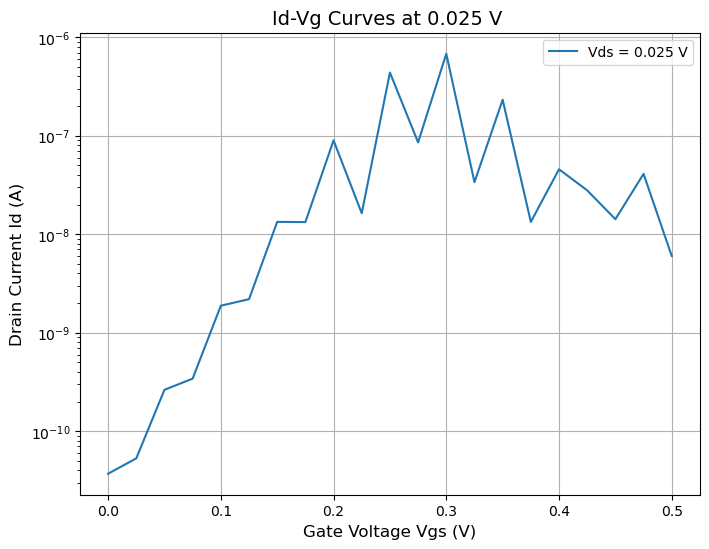

In [7]:
selected_Vds = [0.025]  # Choose specific Vds values to plot
VV = 21  
Vgs = np.linspace(0.0, 0.5, VV)  # Gate-source voltage sweep (V)
Vds = np.linspace(0.0, 0.5, VV)  # Drain-source voltage sweep (V)

II = solver_instance.ds.II

Vg = np.linspace(0.0, 0.5, VV)
current = II[0, :]
current_diff = np.gradient(Vg, np.log10(current * 10e-9)) 
print(current_diff)
plt.figure(figsize=(8, 6))
plt.plot(Vg, current, label=f"Vds = {0.025:.3f} V")
plt.yscale("log")    

plt.xlabel("Gate Voltage Vgs (V)", fontsize=12)
plt.ylabel("Drain Current Id (A)", fontsize=12)
plt.title("Id-Vg Curves at 0.025 V ", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ham